# CS 6140 Machine Learning: Final Group Project
## Philip Butler, Riley Grant, Benjamin Ruzzo

words words words

In [11]:
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sbn
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# df = pd.read_csv("./data/CountyState_Alc_Cig_HDDeath.csv")
df = pd.read_csv("./data/data_all_features.csv")
df.head()

,county_state,hyp_total_2009,cig_total_2012,cig_daily_2012,obs_total_2006,dbt_total_2012,alc_any_2008,alc_heavy_2008,alc_binge_2008,hd_deaths_per100k_over65
0,"Autauga, AL",38.87,25.10,18.41,67.26,11.44,41.2,6.0,13.1,1292.6
1,"Baldwin, AL",36.79,20.90,16.02,76.59,9.76,55.1,9.1,17.7,1182.2
2,"Barbour, AL",47.63,26.25,18.73,59.95,14.65,37.0,5.6,12.0,1508.6
3,"Bibb, AL",43.28,29.41,22.62,59.95,12.32,34.2,5.2,11.6,1362.3
4,"Blount, AL",40.80,27.17,19.88,62.09,11.14,34.1,4.8,10.8,1327.2


## Clean and Join Disparate Data Sets

In [12]:
import json

In [13]:
# clean alcohol dataset
def clean_alcohol(year, saveHuh):
    
    # import the cigarette data
    alc_df = pd.read_csv('data/clean_alcohol_allyears.csv')

    col_to_keep_any = str(year) + " any"
    col_to_keep_heavy = str(year) + " heavy"
    col_to_keep_binge = str(year) + " binge"

    # get list of columns to keep
    list_column_names = list(alc_df)
    list_column_names.remove(col_to_keep_any)
    list_column_names.remove(col_to_keep_heavy)
    list_column_names.remove(col_to_keep_binge)
    list_column_names.remove('county_state')

    # # drop irrelevant rows
    # hyp_df = hyp_df.dropna(subset=['County']) # drop all 'NaN' counties

    # drop everything that's not the given year, or county and state
    alc_df.drop(list_column_names, axis=1, inplace=True)

    # # drop unneeded columns
    # # reorder the whole thing
    # hyp_df = hyp_df[['county_state', 'hyp_total_' + str(year_to_keep),'State', 'state_abbrev','County']]
    alc_df.rename(
        columns = 
        {
            col_to_keep_any: 'alc_any_' + str(year), 
            col_to_keep_heavy: 'alc_heavy_' + str(year),
            col_to_keep_binge: 'alc_binge_' + str(year)
        }, inplace=True)
    # hyp_df.drop(['state', 'state_abbrev', 'county'], axis=1, inplace=True)

    # drop the old index column that exists in the csv for some reason

    # reset index
    alc_df.reset_index(drop=True, inplace=True)

    if saveHuh:
        alc_df.to_csv('data/clean_alcohol.csv', index = False)

    return alc_df

In [14]:
# clean cigarette dataset
def clean_cigarette(year, saveHuh):


    # import the cigarette data
    cig_df = pd.read_csv('data/original_cigarette.csv')

    # putting this bad larry as a variable so we can change which year
    #   if we do correlation stuff later on in the process
    year_to_keep = year


    # === clean data 

    # clean the cigarette dataframe

    # drop irrelevant rows
    cig_df = cig_df.dropna(subset=['county']) # drop all 'NaN' counties
    cig_df = cig_df[cig_df.sex == 'Both'] # keep only 'both' sexes row
    cig_df = cig_df[cig_df.year == year_to_keep] # keep only one year

    # rename counties for consistenty, drop any suffixes (__ County, __ Borough, __ City, ..., etc)
    cig_df['county_short'] = cig_df['county']
    cig_df.loc[cig_df['county'].str.endswith(" County"), 'county_short'] = cig_df['county'].str.removesuffix(" County") # drop county, works for most
    cig_df.loc[cig_df['county'].str.endswith(" Parish"), 'county_short'] = cig_df['county'].str.removesuffix(" Parish") # drop 'Parish', for Louisiana
    cig_df.loc[cig_df['county'].str.endswith(" City"), 'county_short'] = cig_df['county'].str.removesuffix(" City") # drop 'City', for a few states. More consistent to drop it all the time.

    # alaska shiz - so inconsistent
    cig_df.loc[cig_df['county'].str.endswith(" Borough"), 'county_short'] = cig_df['county'].str.removesuffix(" Borough") 
    cig_df.loc[cig_df['county'].str.endswith(" Census Area"), 'county_short'] = cig_df['county'].str.removesuffix(" Census Area") 
    cig_df.loc[cig_df['county'].str.endswith(" Municipality"), 'county_short'] = cig_df['county'].str.removesuffix(" Municipality") 




    # === rename states to country code, add a column
    # import json
    sta_json = open('data/states_to_abbrev.json')
    states_to_abbrev_dict = json.load(sta_json)

    cig_df['state_abbrev'] = cig_df['state']
    cig_df['state_abbrev'] = cig_df.loc[:, 'state']


    cig_df = cig_df.replace( {
        'state_abbrev': states_to_abbrev_dict
    })



    # # create single column for joining
    # cig_df['state_county'] = cig_df['county']
    cig_df['county_state'] = cig_df.loc[:, 'county_short'] + ', ' + cig_df.loc[:, 'state_abbrev']



    # rename column headers - make sure they're readable as cigarette data
    cig_df.rename(columns = {
        'state'      : 'state_full',
        'county'     : 'county_full',
        'sex'        : 'cig_sex',
        'year'       : 'cig_year',
        'total_mean' : 'cig_total',
        'total_lb'   : 'cig_total_lb',
        'total_ub'   : 'cig_total_ub',
        'daily_mean' : 'cig_daily',
        'daily_lb'   : 'cig_daily_lb',
        'daily_ub'   : 'cig_daily_ub',
    }, inplace = True)


    # re-order the whole bad larry
    cig_df = cig_df[ 
        [
            'county_state', 'county_short', 'state_abbrev',
            'cig_total', 'cig_daily',
            'county_full', 'state_full',
            'cig_sex', 'cig_year',
            'cig_total_lb', 'cig_total_ub', 'cig_daily_lb', 'cig_daily_ub',
        ] 
    ]

    # drop the old index column
    # cig_df.drop(cig_df.columns[0], axis=1, inplace=True) # drop the old index
    cig_df.reset_index(drop=True, inplace=True)

    # OPTIONAL - remove all unneeded columns? just keep the total_mean, daily_mean
    cig_df.drop(['cig_sex', 'cig_year'], axis=1, inplace=True) # drop sex and year, irrelevant now
    cig_df.drop(['cig_total_lb', 'cig_total_ub', 'cig_daily_lb', 'cig_daily_ub'], axis=1, inplace=True) # drop upper and lower bounds, only keep mean
    cig_df.drop(['county_short', 'state_abbrev', 'county_full', 'state_full'], axis=1, inplace=True)

    cig_df.rename(columns={
        'cig_total': 'cig_total_' + str(year),
        'cig_daily': 'cig_daily_' + str(year)
    }, inplace=True)

    # optional - save it as a csv
    if saveHuh:
        cig_df.to_csv('data/clean_cigarette.csv', index = False)
    
    return cig_df

In [15]:
# clean the diabetes dataset
def clean_diabetes(year, saveHuh):
    
    # import the cigarette data
    dbt_df = pd.read_csv('data/modified_diabetes.csv')

    # drop irrelevant rows
    dbt_df = dbt_df.dropna(subset=['County']) # drop all 'NaN' counties

    col_to_keep = "Prevalence, " + str(year) + ", Both Sexes"

    # get list of columns to keep
    list_column_names = list(dbt_df)
    list_column_names.remove(col_to_keep)
    list_column_names.remove('State')
    list_column_names.remove('County')

    # drop everything that's not the given year, or county and state
    dbt_df.drop(list_column_names, axis=1, inplace=True)

    # fix up counties
    dbt_df.loc[dbt_df['County'].str.endswith(" County"), 'county_short'] = dbt_df['County'].str.removesuffix(" County") # drop county, works for most
    dbt_df.loc[dbt_df['County'].str.endswith(" Parish"), 'county_short'] = dbt_df['County'].str.removesuffix(" Parish") # drop county, works for most
    dbt_df.loc[dbt_df['County'].str.endswith(" City"), 'county_short'] = dbt_df['County'].str.removesuffix(" City") # drop county, works for most

    # alaska shiz
    dbt_df.loc[dbt_df['County'].str.endswith(" Borough"), 'county_short'] = dbt_df['County'].str.removesuffix(" Borough") # drop county, works for most
    dbt_df.loc[dbt_df['County'].str.endswith(" Census Area"), 'county_short'] = dbt_df['County'].str.removesuffix(" Census Area") # drop county, works for most
    dbt_df.loc[dbt_df['County'].str.endswith(" Municipality"), 'county_short'] = dbt_df['County'].str.removesuffix(" Municipality") # drop county, works for most



    # get state codes
    sta_json = open('data/states_to_abbrev.json')
    states_to_abbrev_dict = json.load(sta_json)
    dbt_df['state_abbrev'] = dbt_df['State']
    dbt_df['state_abbrev'] = dbt_df.loc[:, 'State']
    dbt_df = dbt_df.replace( {
        'state_abbrev': states_to_abbrev_dict
    })


    # create column to join on
    dbt_df['county_state'] = dbt_df.loc[:, 'county_short'] + ', ' + dbt_df.loc[:, 'state_abbrev']

    # drop unneeded columns
    # reorder the whole thing
    dbt_df.rename(columns = {'State': 'state', 'County': 'county', "Prevalence, " + str(year) + ", Both Sexes": "dbt_total_" + str(year)}, inplace=True)
    dbt_df = dbt_df[['county_state', 'dbt_total_' + str(year),'state', 'state_abbrev','county']]
    dbt_df.drop(['state', 'state_abbrev', 'county'], axis=1, inplace=True)

    # reset index
    dbt_df.reset_index(drop=True, inplace=True)

    if saveHuh:
        dbt_df.to_csv('data/clean_diabetes.csv', index = False)

    return dbt_df
    

In [16]:
# clean the heart disease dataset
def clean_heartdisease(saveHuh):
    
    # import the cigarette data
    hdd_df = pd.read_csv('data/CountyState_Alc_Cig_HDDeath.csv')

    # get list of columns to keep
    list_column_names = list(hdd_df)
    list_column_names.remove('deaths-per-100k')
    list_column_names.remove('county_state')


    # drop everything that's not the given year, or county and state
    hdd_df.drop(list_column_names, axis=1, inplace=True)

    hdd_df.rename(columns = {'deaths-per-100k': 'hd_deaths_per100k_over65'}, inplace=True)
    # hyp_df.drop(['state', 'state_abbrev', 'county'], axis=1, inplace=True)

    # reset index
    hdd_df.reset_index(drop=True, inplace=True)

    if saveHuh:
        hdd_df.to_csv('data/clean_heart_disease.csv', index = False)

    return hdd_df
    

In [17]:
# clean the hypertension dataset
def clean_hypertension(year, saveHuh):
    
    # import the cigarette data
    hyp_df = pd.read_csv('data/original_hypertension.csv')

    # putting this bad larry as a variable so we can change which year
    #   if we do correlation stuff later on in the process
    # year_to_keep = 2009
    year_to_keep = year

    col_to_keep_male = "Total, Male, " + str(year_to_keep)
    col_to_keep_female = "Total, Female, " + str(year_to_keep)
    # print(col_to_keep_female)

    # get list of columns to keep
    list_column_names = list(hyp_df)
    list_column_names.remove(col_to_keep_male)
    list_column_names.remove(col_to_keep_female)
    list_column_names.remove('State')
    list_column_names.remove('County')


    # drop irrelevant rows
    hyp_df = hyp_df.dropna(subset=['County']) # drop all 'NaN' counties

    # drop everything that's not the given year, or county and state
    hyp_df.drop(list_column_names, axis=1, inplace=True)

    # average the male and female, drop them after making combined one
    hyp_df['hyp_total_' + str(year_to_keep)] = ( pd.to_numeric(hyp_df[col_to_keep_male].str[:-1]) + pd.to_numeric(hyp_df[col_to_keep_male].str[:-1]) ) / 2
    hyp_df.drop([col_to_keep_male, col_to_keep_female], axis=1, inplace=True)



    # fix up counties
    hyp_df.loc[hyp_df['County'].str.endswith(" County"), 'county_short'] = hyp_df['County'].str.removesuffix(" County") # drop county, works for most
    hyp_df.loc[hyp_df['County'].str.endswith(" Parish"), 'county_short'] = hyp_df['County'].str.removesuffix(" Parish") # drop county, works for most
    hyp_df.loc[hyp_df['County'].str.endswith(" City"), 'county_short'] = hyp_df['County'].str.removesuffix(" City") # drop county, works for most

    # alaska shiz
    hyp_df.loc[hyp_df['County'].str.endswith(" Borough"), 'county_short'] = hyp_df['County'].str.removesuffix(" Borough") # drop county, works for most
    hyp_df.loc[hyp_df['County'].str.endswith(" Census Area"), 'county_short'] = hyp_df['County'].str.removesuffix(" Census Area") # drop county, works for most
    hyp_df.loc[hyp_df['County'].str.endswith(" Municipality"), 'county_short'] = hyp_df['County'].str.removesuffix(" Municipality") # drop county, works for most



    # get state codes
    sta_json = open('data/states_to_abbrev.json')
    states_to_abbrev_dict = json.load(sta_json)
    hyp_df['state_abbrev'] = hyp_df['State']
    hyp_df['state_abbrev'] = hyp_df.loc[:, 'State']
    hyp_df = hyp_df.replace( {
        'state_abbrev': states_to_abbrev_dict
    })


    # create column to join on
    hyp_df['county_state'] = hyp_df.loc[:, 'county_short'] + ', ' + hyp_df.loc[:, 'state_abbrev']

    # drop unneeded columns
    # reorder the whole thing
    hyp_df = hyp_df[['county_state', 'hyp_total_' + str(year_to_keep),'State', 'state_abbrev','County']]
    hyp_df.rename(columns = {'State': 'state', 'County': 'county'}, inplace=True)
    hyp_df.drop(['state', 'state_abbrev', 'county'], axis=1, inplace=True)

    # reset index
    hyp_df.reset_index(drop=True, inplace=True)

    if saveHuh:
        hyp_df.to_csv('data/clean_hypertension.csv', index = False)

    return hyp_df
    

In [18]:
# clean the obesity dataset
def clean_obesity(year, saveHuh):
    
    # import the cigarette data
    obs_df = pd.read_csv('data/original_obesity.csv')

    # putting this bad larry as a variable so we can change which year

    col_to_keep = 'Prevalence ' + str(year) + ' (%)'
    # print(col_to_keep_female)

    # get list of columns to keep
    list_column_names = list(obs_df)
    list_column_names.remove(col_to_keep)
    list_column_names.remove('State')
    list_column_names.remove('County')


    # drop irrelevant rows
    obs_df = obs_df.dropna(subset=['County']) # drop all 'NaN' counties
    obs_df = obs_df[obs_df.Sex != 'Male'] # kinda janky, tbh

    # drop everything that's not the given year, or county and state
    obs_df.drop(list_column_names, axis=1, inplace=True)

    # yah
    obs_df.rename(
        columns = 
        {
            'Prevalence ' + str(year) + ' (%)': 'obs_total_' + str(year),
            'State': 'state', 
            'County': 'county_state'
        }, inplace=True)

    obs_df.drop(['state'], axis=1, inplace=True)

    # reset index
    obs_df.reset_index(drop=True, inplace=True)
    # print(obs_df.head())

    if saveHuh:
        obs_df.to_csv('data/clean_obesity.csv', index = False)

    return obs_df
    

In [19]:
hyp_df = clean_hypertension(2009, True) # 2001, 2009    : 2009 is strongest
cig_df = clean_cigarette(2012, True)    # 1996 - 2012   : 2012 is strongest
obs_df = clean_obesity(2011, True)      # 2001 - 2011   : 2006 is least negative correlation (as time increases, more people are obese, and die of other complications?)
dbt_df = clean_diabetes(2012, True)     # 1999 - 2012   : 2012 is strongest (prolly similar, more time == more diabetes)
alc_df = clean_alcohol(2012, True)      # 2005 - 2012   : 2008 is least negative correlation
hdd_df = clean_heartdisease(True)  


# == change this line to check each correlation manually, looking for the best one
# merge_df = hyp_df.join( hdd_df.set_index('county_state'), on='county_state')
# merge_df = cig_df.join( hdd_df.set_index('county_state'), on='county_state')
# merge_df = obs_df.join( hdd_df.set_index('county_state'), on='county_state')
# merge_df = dbt_df.join( hdd_df.set_index('county_state'), on='county_state')
merge_df = alc_df.join( hdd_df.set_index('county_state'), on='county_state')

merge_df.dropna(inplace=True)

# check correlation here
print(merge_df.corr())

                          alc_any_2012  alc_heavy_2012  alc_binge_2012  \
alc_any_2012                  1.000000        0.794296        0.851249   
alc_heavy_2012                0.794296        1.000000        0.882982   
alc_binge_2012                0.851249        0.882982        1.000000   
hd_deaths_per100k_over65     -0.503848       -0.381379       -0.364785   

                          hd_deaths_per100k_over65  
alc_any_2012                             -0.503848  
alc_heavy_2012                           -0.381379  
alc_binge_2012                           -0.364785  
hd_deaths_per100k_over65                  1.000000  


In [ ]:
# join all the data for individual year, using the best correlations found from the above cell
hyp_df = clean_hypertension(2009, True)
cig_df = clean_cigarette(2012, True)
obs_df = clean_obesity(2006, True)
dbt_df = clean_diabetes(2012, True)
alc_df = clean_alcohol(2008, True)
hdd_df = clean_heartdisease(True)


# merge all the datasets and printout the correlation matrix
merge_df = hyp_df.join( cig_df.set_index('county_state'), on='county_state')
merge_df = merge_df.join( obs_df.set_index('county_state'), on='county_state')
merge_df = merge_df.join( dbt_df.set_index('county_state'), on='county_state')
merge_df = merge_df.join( alc_df.set_index('county_state'), on='county_state')
merge_df = merge_df.join( hdd_df.set_index('county_state'), on='county_state')

merge_df.dropna(inplace=True)

merge_df.to_csv('data/data_all_features.csv', index = False)

## Observe Trends in Data

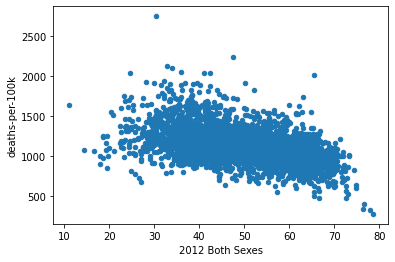

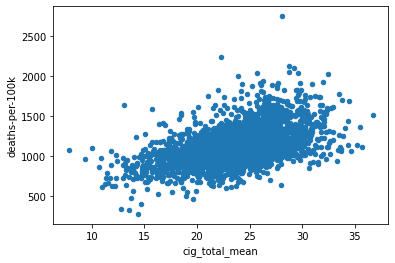

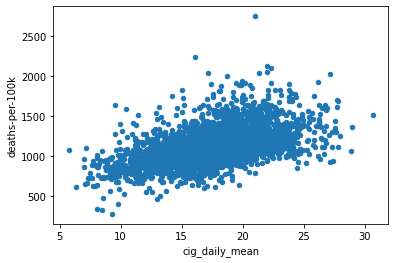

In [2]:
# Plot all features against deaths-per-100k - Ignores first and last columns of df (county_state and deaths-per-100k)
for col in df.columns[1:-1]:
    df.plot.scatter(x=col, y='deaths-per-100k')

In [3]:
full_data = pd.read_csv('.\data\data_all_features.csv')
full_data.head()

,county_state,hyp_total_2009,cig_total_2012,cig_daily_2012,obs_total_2006,dbt_total_2012,alc_any_2008,alc_heavy_2008,alc_binge_2008,hd_deaths_per100k_over65
0,"Autauga, AL",38.87,25.10,18.41,67.26,11.44,41.2,6.0,13.1,1292.6
1,"Baldwin, AL",36.79,20.90,16.02,76.59,9.76,55.1,9.1,17.7,1182.2
2,"Barbour, AL",47.63,26.25,18.73,59.95,14.65,37.0,5.6,12.0,1508.6
3,"Bibb, AL",43.28,29.41,22.62,59.95,12.32,34.2,5.2,11.6,1362.3
4,"Blount, AL",40.80,27.17,19.88,62.09,11.14,34.1,4.8,10.8,1327.2


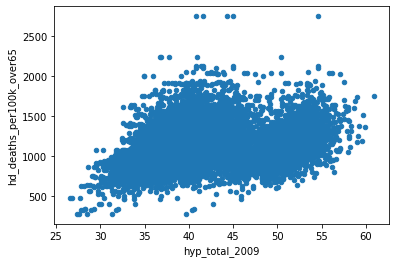

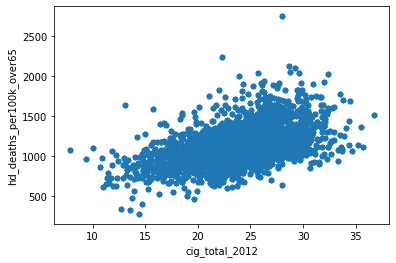

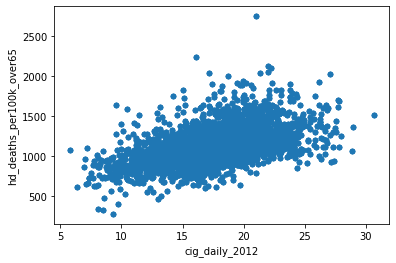

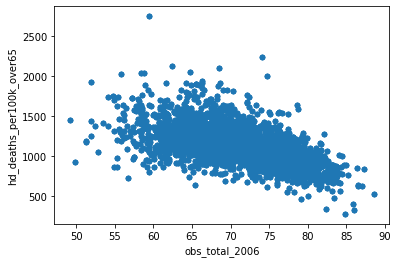

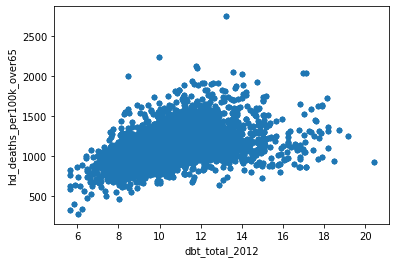

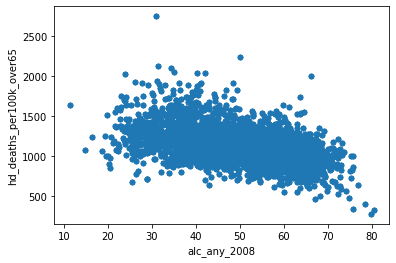

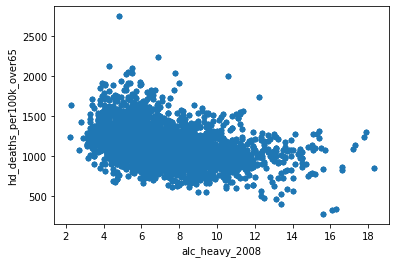

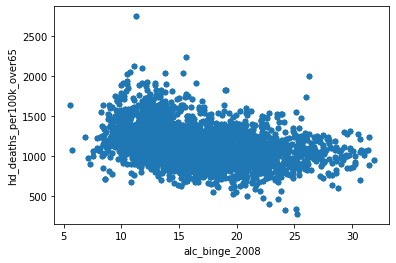

In [4]:
#All features for full data set plotted against hd_deaths_per100k_over65
for col in full_data.columns[1:-1]:
    full_data.plot.scatter(x=col, y='hd_deaths_per100k_over65')

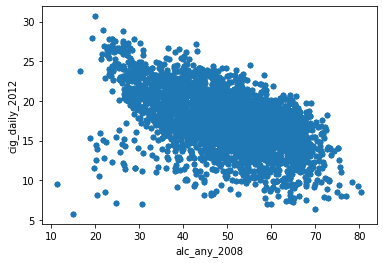

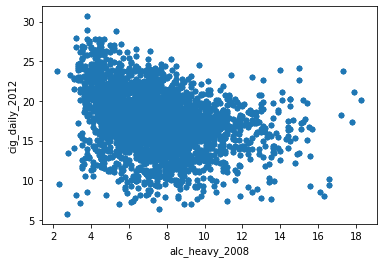

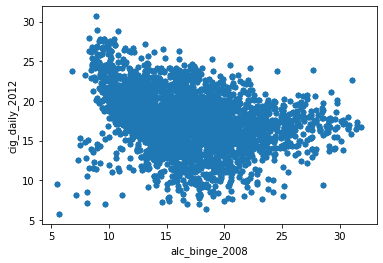

In [5]:
#All alcohol versus cig_total
for col in full_data.columns[6:9]:
    full_data.plot.scatter(x=col ,y='cig_daily_2012')

<AxesSubplot:>

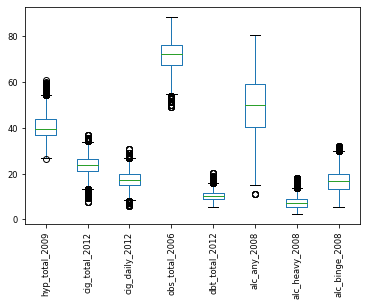

In [6]:
#Boxplots of all features but location
data_features = full_data.drop(['county_state','hd_deaths_per100k_over65'],axis = 1)

data_features.boxplot(grid=False,fontsize='small',rot=90)

<AxesSubplot:>

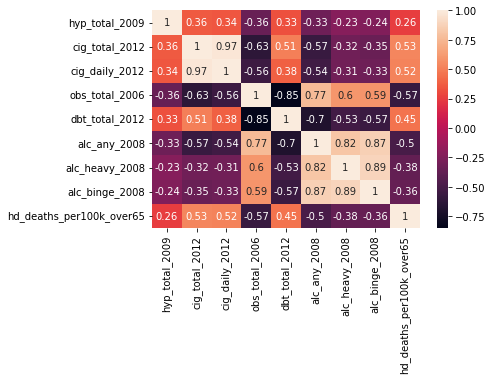

In [7]:
#Heatmap for feature correlation
full_data = full_data.drop(['county_state'],axis=1)
sbn.heatmap(full_data.corr(),annot=True)

<AxesSubplot:>

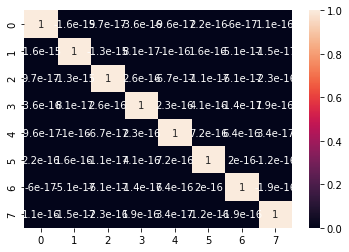

In [8]:
from sklearn.decomposition import PCA
#PCA transformation down to two dimensions and then correlation heatmap
pca = PCA(8)
transformed = pca.fit_transform(data_features)
pca_data = pd.DataFrame(transformed)
sbn.heatmap(pca_data.corr(),annot=True)

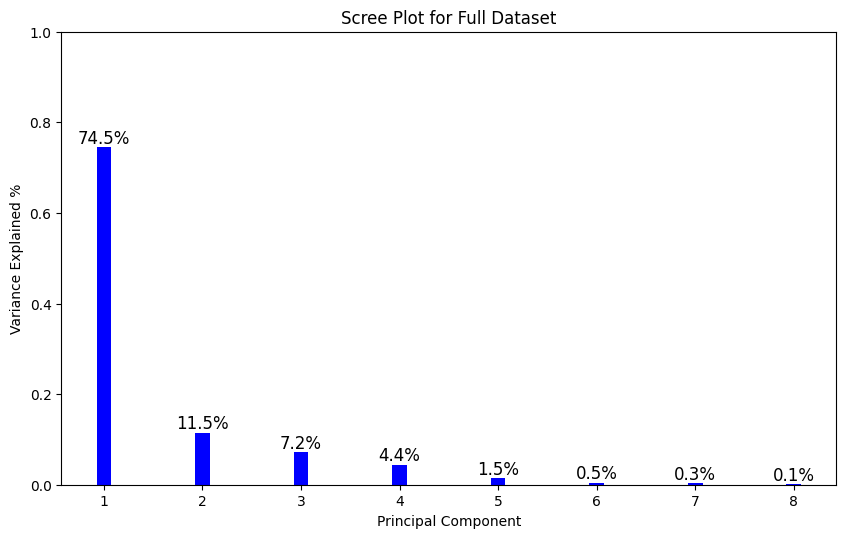

In [9]:
var = pca.explained_variance_ratio_
plt.figure(figsize=(10,6), dpi=100)
plot = plt.subplot(111)
plot.bar(['1','2','3','4','5','6','7','8'],var, width = 0.15, color = ['blue'])
plt.ylim(0,1)
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained %")
plt.title("Scree Plot for Full Dataset")
for bar in plot.patches:
    plot.annotate(format(bar.get_height()*100, '.1f') + str('%'), (bar.get_x() + bar.get_width() / 2, bar.get_height()), ha= "center", va='bottom', size = 12)

In [10]:
#Linear Regression model with full data and 10 fold cross validation
X= data_features
y = full_data['hd_deaths_per100k_over65']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Training scores: [0.38930457 0.36558557 0.40753759 0.33454252 0.41255188 0.40998566
 0.33840611 0.37122628 0.38365187 0.41093264]
Mean squared error: 31325.861786457117
Coefficient of determination (R2): 0.3982300661261181
[1270.43124993 1121.02093822 1210.44768903 ... 1011.93114594 1068.73693201
 1095.50194196]


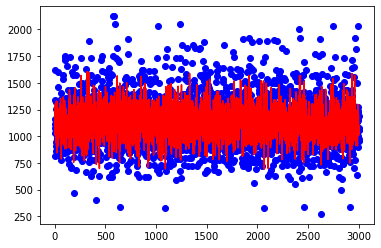

In [11]:
lg = LinearRegression()
scores = cross_val_score(lg, X_train, y_train, cv= 10)
print("Training scores: " + str(scores))
lg = lg.fit(X_train, y_train)
y_pred = lg.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))

#Scatter plot of linear regression on all the data features
X_test=np.arange(0,len(X_test),1)
print(y_pred)
plt.scatter(X_test,y_test, color="blue")
plt.plot(X_test,y_pred, color = "red")

In [12]:
#PCR model using the PCA transformed data with 3 components
X= data_features
y = full_data['hd_deaths_per100k_over65']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Mean squared error: 31359.130497111044
Coefficient of determination (R2): 0.380759712568951
[1208.50652645 1009.48201719 1159.28039259 ...  999.60873764  812.07299257
 1151.76820099]


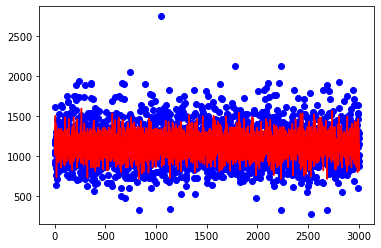

In [13]:
pcr = make_pipeline(StandardScaler(), PCA(n_components = 3), LinearRegression())
pcr.fit(X_train, y_train)

y_pred = pcr.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))
#Scatter plot of PCA linear regression on all the 3 components
X_test=np.arange(0,len(X_test),1)
print(y_pred)
plt.scatter(X_test,y_test, color="blue")
plt.plot(X_test,y_pred, color = "red")

In [14]:
#Linear regression model with one alcohol column, one cig column, and the rest of the data columns
alcohol = ['alc_any_2008', 'alc_heavy_2008', 'alc_binge_2008']
cig = ['cig_total_2012', 'cig_daily_2012']

one_cig_one_alc_dfs = list()
for a in range(0,len(alcohol)):
    for c in range(0,len(cig)):
        a1 = alcohol[a]
        if a+1 == len(alcohol):
            a2 = alcohol[0]
        else: 
            a2 = alcohol[a+1]
        c= cig[c]
        data = data_features.drop(columns = ([a1,a2,c]))
        one_cig_one_alc_dfs.append(data)
        



In [15]:
#Linear Regression model with one alcohol column, one cig column, and 10 fold cross validation
for i in range(0,len(one_cig_one_alc_dfs)):
    X= one_cig_one_alc_dfs[i]
    y = full_data['hd_deaths_per100k_over65']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    print(X.columns.values.tolist())
    
    lg = LinearRegression()
    scores = cross_val_score(lg, X_train, y_train, cv= 10)
    print("Training scores: " + str(scores))
    lg = lg.fit(X_train, y_train)
    y_pred = lg.predict(X_test)
    print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
    print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')

    

['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_binge_2008']
Training scores: [0.3628121  0.3597419  0.36357686 0.42694795 0.40154925 0.3900153
 0.34652286 0.39028916 0.37086062 0.35177579]
Mean squared error: 30552.143980455898
Coefficient of determination (R2): 0.40016874734569896

['hyp_total_2009', 'cig_total_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_binge_2008']
Training scores: [0.37591795 0.37421233 0.38934267 0.42100775 0.37194211 0.40747213
 0.36293707 0.34717477 0.3855939  0.31672492]
Mean squared error: 30581.16380424368
Coefficient of determination (R2): 0.37587130849704387

['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_any_2008']
Training scores: [0.40160933 0.38809911 0.37756222 0.37920911 0.33962109 0.41596767
 0.38908139 0.37743795 0.32986302 0.40195146]
Mean squared error: 32455.556429362427
Coefficient of determination (R2): 0.39022441399248775

['hyp_total_2009', 'cig_total_2012', 'obs_total_2006', '

Training scores: [0.08439787 0.04450959 0.05164186 0.07105341 0.05833713 0.05199726
 0.07222191 0.07178019 0.06991221 0.06296813]
Mean squared error: 49428.3280432468
Coefficient of determination (R2): 0.06510972966620798



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


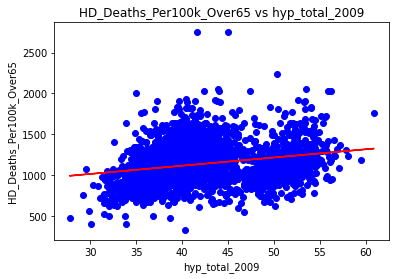

Training scores: [0.28490277 0.31566187 0.27230012 0.25590698 0.27819546 0.25070225
 0.28329757 0.31422416 0.30101084 0.29483197]
Mean squared error: 39109.43704482809
Coefficient of determination (R2): 0.276963379478502



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


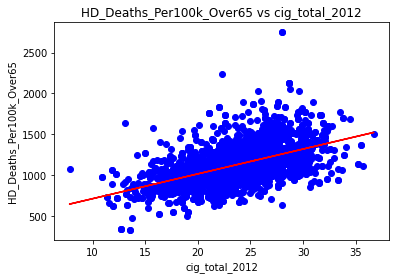

C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)


Training scores: [0.29417484 0.29239538 0.22973995 0.28121765 0.25111996 0.26509412
 0.27923406 0.27965222 0.28299634 0.24802382]
Mean squared error: 40221.67480350221
Coefficient of determination (R2): 0.24746043736977819



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


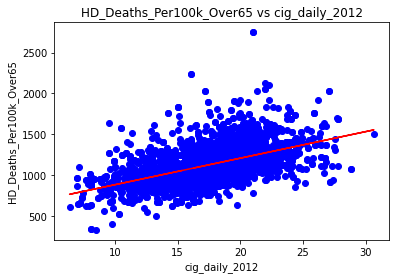

Training scores: [0.29940277 0.31560702 0.33480305 0.30034217 0.32719338 0.33085109
 0.32395354 0.33884663 0.30112074 0.35752407]


C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)


Mean squared error: 35863.25249691428
Coefficient of determination (R2): 0.3139873579288721



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


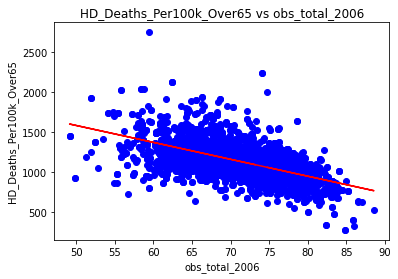

Training scores: [0.15828213 0.20443157 0.23319719 0.20190572 0.21442275 0.22316338
 0.18670124 0.16732373 0.20045743 0.20564974]
Mean squared error: 39707.22785041539
Coefficient of determination (R2): 0.22422964655638256



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


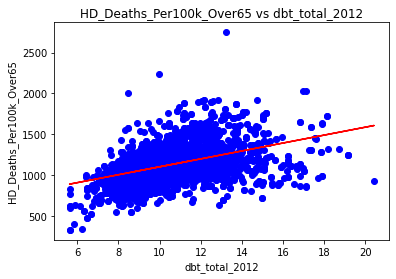

Training scores: [0.28200974 0.22333969 0.24863627 0.24131256 0.27272115 0.25600087
 0.23636964 0.25657774 0.2327177  0.26422538]
Mean squared error: 40356.460321262566
Coefficient of determination (R2): 0.23810808478966194



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


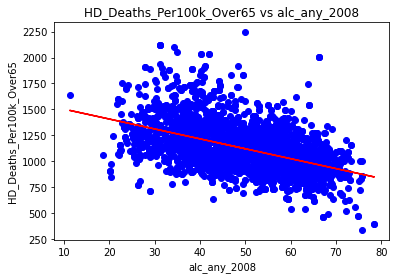

Training scores: [0.12563259 0.11786416 0.15019904 0.14019028 0.14012231 0.16111103
 0.15676721 0.15569228 0.13125157 0.13131652]
Mean squared error: 45334.84012520922
Coefficient of determination (R2): 0.1414149753182231



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


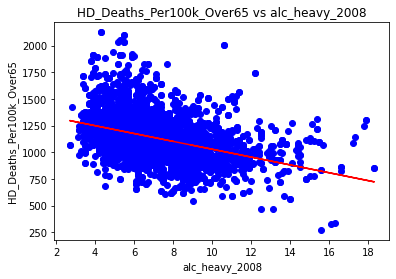

Training scores: [0.13135418 0.13876361 0.11632684 0.15416091 0.12893586 0.11836418
 0.13512197 0.11299042 0.14895676 0.11747081]
Mean squared error: 45308.87735799026
Coefficient of determination (R2): 0.11882820078406242



C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:13: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  lg = lg.fit(X_train[:,np.newaxis], y_train)
C:\Users\ruzzo\AppData\Local\Temp\ipykernel_10572\1063385818.py:14: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y_pred = lg.predict(X_test[:,np.newaxis])


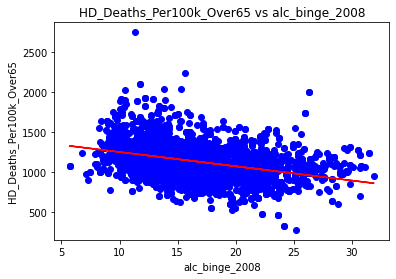

In [16]:
#Linear regression of each feature alone
n,m = data_features.shape
for i in range(0,m):
    
    X = data_features.iloc[:,i]
    y = full_data['hd_deaths_per100k_over65']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    lg = LinearRegression()
    scores = cross_val_score(lg, X_train[:,np.newaxis], y_train, cv= 10)
    print("Training scores: " + str(scores))
  
    lg = lg.fit(X_train[:,np.newaxis], y_train)
    y_pred = lg.predict(X_test[:,np.newaxis])
    print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
    print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')
    
    #Scatter plot of PCA linear regression on all the 3 components
    plt.scatter(X_test,y_test, color="blue")
    plt.plot(X_test,y_pred, color = "red")
    plt.ylabel('HD_Deaths_Per100k_Over65')
    plt.xlabel(data_features.columns[i])
    plt.title('HD_Deaths_Per100k_Over65 vs ' + str(data_features.columns[i]))
    plt.show()

In [17]:
#Lasso regression with all features
X= data_features
y = full_data['hd_deaths_per100k_over65']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [18]:
lasso = Lasso()
scores = cross_val_score(lasso, X_train, y_train, cv= 10)
print("Training scores: " + str(scores))
lasso = lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)))


Training scores: [0.4043737  0.36381756 0.3649714  0.35827186 0.40095314 0.36648136
 0.38360618 0.40319438 0.40072364 0.40167268]
Mean squared error: 31802.08674533631
Coefficient of determination (R2): 0.38342382461906543


In [20]:
#Lasso Regression model with one alcohol column, one cig column, and 10 fold cross validation
for i in range(0,len(one_cig_one_alc_dfs)):
    X= one_cig_one_alc_dfs[i]
    y = full_data['hd_deaths_per100k_over65']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    print(X.columns.values.tolist())
    
    lasso = Lasso()
    scores = cross_val_score(lasso, X_train, y_train, cv= 10)
    print("Training scores: " + str(scores))
    lasso = lasso.fit(X_train, y_train)
    y_pred = lasso.predict(X_test)
    print('Mean squared error: ' + str(mean_squared_error(y_test,y_pred)))
    print('Coefficient of determination (R2): ' + str(r2_score(y_test, y_pred)) + '\n')


['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_binge_2008']
Training scores: [0.41748892 0.39274401 0.39661671 0.39079053 0.38584221 0.39739594
 0.35179076 0.35674738 0.38629407 0.38574036]
Mean squared error: 34206.88875332662
Coefficient of determination (R2): 0.3587577219990137

['hyp_total_2009', 'cig_total_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_binge_2008']
Training scores: [0.36500811 0.3485723  0.37530385 0.38694081 0.37721115 0.36628659
 0.37470979 0.30267171 0.412556   0.39140283]
Mean squared error: 32551.63279411452
Coefficient of determination (R2): 0.39721575947596033

['hyp_total_2009', 'cig_daily_2012', 'obs_total_2006', 'dbt_total_2012', 'alc_any_2008']
Training scores: [0.35834663 0.38106647 0.40772721 0.39204107 0.35305684 0.36995456
 0.39272446 0.38481139 0.40707856 0.36825203]
Mean squared error: 32877.28029395165
Coefficient of determination (R2): 0.3847592415057639

['hyp_total_2009', 'cig_total_2012', 'obs_total_2006', 'dbt